## Work
1. 試比較 save_best_only 與否的差異
  * save_best_only：如果save_best_only = True，被監測數據的最佳模型就不會被覆蓋。
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test
  * save_weights_only：如果True，那麼只有模型的權重會被保存（model.save_weights（filepath）），否則的話，整個模型會被保存（model.save（filepath））。

In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

## 1. 試比較 save_best_only 與否的差異
* save_best_only = Fase，被監測數據的最佳模型就會被覆蓋。
  * 可以由圖表(Red)中看出，由 load file 得出的參數，再計算所得的 loss, acc 都並非是最佳的那一組。
  * 而圖表(Green)，則是原本 save_best_only=True 時的設置。

In [7]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp_not_save_best_only.h5", 
                             monitor="val_loss", 
                             save_best_only=False)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

Epoch 46/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5514 - acc: 0.8387 - val_loss: 1.6435 - val_acc: 0.4870
Epoch 47/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5344 - acc: 0.8462 - val_loss: 1.6491 - val_acc: 0.4943
Epoch 48/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5182 - acc: 0.8522 - val_loss: 1.6789 - val_acc: 0.4843
Epoch 49/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5006 - acc: 0.8592 - val_loss: 1.6734 - val_acc: 0.4891
Epoch 50/50
10000/10000 [==============================] - 1s 53us/step


In [14]:
# Load back
model = keras.models.load_model("./tmp_not_save_best_only.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

model_org = keras.models.load_model("./tmp.h5")
loss_loadback_org, acc_loadback_org = model_org.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 82us/step


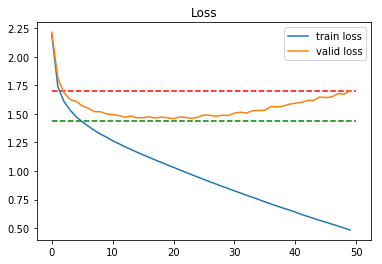

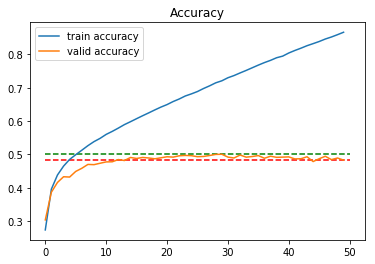

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=loss_loadback_org, xmin=0, xmax=len(train_loss), colors='g', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.hlines(y=acc_loadback_org, xmin=0, xmax=len(train_loss), colors='g', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## 2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test
save_weights_only：如果True，那麼只有模型的權重會被保存（model.save_weights（filepath）），否則的話，整個模型會被保存（model.save（filepath））。。

In [17]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp_save_weight_only.h5", 
                             monitor="val_loss", 
                             save_best_only=True, 
                             save_weights_only=True)

In [18]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5024 - acc: 0.8583 - val_loss: 1.6510 - val_acc: 0.4884
